In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

100%|██████████| 9.91M/9.91M [00:13<00:00, 730kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 103kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 642kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 24.6MB/s]


In [2]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [3]:
train_dataset.__len__()

60000

In [4]:
train_dataset.__getitem__(5)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [6]:
train_dataset.__len__()

55000

In [7]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

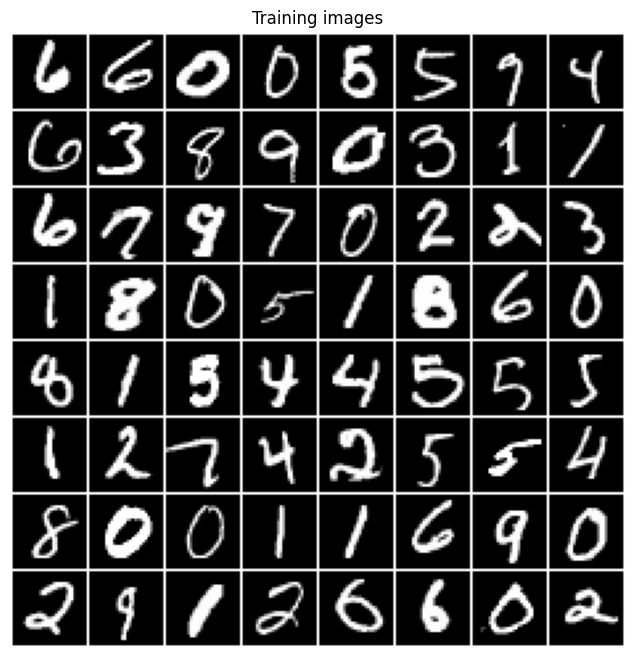

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, labels in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [10]:
labels

tensor([6, 6, 0, 0, 5, 5, 7, 4, 6, 3, 8, 9, 0, 3, 1, 1, 6, 7, 9, 7, 0, 2, 2, 3,
        1, 8, 0, 5, 1, 8, 6, 0, 8, 1, 5, 4, 4, 5, 5, 5, 1, 2, 7, 4, 2, 5, 5, 4,
        8, 0, 0, 1, 1, 6, 9, 0, 2, 9, 1, 2, 6, 6, 0, 2])

In [13]:
images.shape

torch.Size([64, 1, 28, 28])

In [14]:
import torch

torch.flatten(images, start_dim=1).shape # batchsize, features

torch.Size([64, 784])

In [15]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x): # x: 64 * 1 * 28 * 28
        x = torch.flatten(x, start_dim=1) # 64 * 784
        logits = self.all_layers(x)
        return logits

In [16]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [17]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs = 10

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

Epoch: 001/010 | Batch 000/860 | Train Loss: 2.34
Epoch: 001/010 | Batch 250/860 | Train Loss: 0.68
Epoch: 001/010 | Batch 500/860 | Train Loss: 0.29
Epoch: 001/010 | Batch 750/860 | Train Loss: 0.30
Train Acc 88.70% | Val Acc 88.22%
Epoch: 002/010 | Batch 000/860 | Train Loss: 0.36
Epoch: 002/010 | Batch 250/860 | Train Loss: 0.41
Epoch: 002/010 | Batch 500/860 | Train Loss: 0.44
Epoch: 002/010 | Batch 750/860 | Train Loss: 0.25
Train Acc 91.84% | Val Acc 91.12%
Epoch: 003/010 | Batch 000/860 | Train Loss: 0.28
Epoch: 003/010 | Batch 250/860 | Train Loss: 0.20
Epoch: 003/010 | Batch 500/860 | Train Loss: 0.18
Epoch: 003/010 | Batch 750/860 | Train Loss: 0.26
Train Acc 93.70% | Val Acc 92.84%
Epoch: 004/010 | Batch 000/860 | Train Loss: 0.18
Epoch: 004/010 | Batch 250/860 | Train Loss: 0.13
Epoch: 004/010 | Batch 500/860 | Train Loss: 0.26
Epoch: 004/010 | Batch 750/860 | Train Loss: 0.22
Train Acc 94.82% | Val Acc 93.62%
Epoch: 005/010 | Batch 000/860 | Train Loss: 0.12
Epoch: 005/010

In [18]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 97.24%
Val Acc 95.62%
Test Acc 96.43%
